In [1]:
pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ca5734e8988d1f10af45ad9e077e250f0925ae81dc5db0e43f0650f50441a5a2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=49878431ab3ec20a1a1cbe563462d1b1751b2f9397994abb7c5308be054630d5
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import random
import cv2


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.transforms import functional as TF

from PIL import Image, ImageFilter
import numpy as np
from sklearn.metrics import f1_score
from segmentation_models_pytorch import Unet
import matplotlib.pyplot as plt

# Setting GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device


device(type='cuda')

# Creating the custom dataset

In [4]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_test = is_test
        
        if is_test:
            # For test set, look for images in subdirectories
            self.images = []
            for test_dir in sorted(os.listdir(image_dir)):
                dir_path = os.path.join(image_dir, test_dir)
                if os.path.isdir(dir_path):
                    for img in os.listdir(dir_path):
                        if img.endswith(('.png', '.jpg', '.jpeg')):
                            self.images.append(os.path.join(test_dir, img))
        else:
            self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        image = image.resize((416, 416))  
        
        if self.transform:
            image = self.transform(image)
            
        if self.is_test:
            return image, self.images[idx]  
        else:
            mask_path = os.path.join(self.mask_dir, self.images[idx])
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((416, 416))  
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()
            return image, mask

# Trial-1: Training on the original data

# Creating transformations, dataloaders

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Make sure to adjust the path here based on your work

In [6]:
# Create training datasets
train_val_dataset = RoadSegmentationDataset(
    image_dir="/kaggle/input/satellite-images-for-road-segmentation/training/images",
    mask_dir="/kaggle/input/satellite-images-for-road-segmentation/training/groundtruth",
    transform=transform
)

# Create test dataset
test_dataset = RoadSegmentationDataset(
    image_dir="/kaggle/input/satellite-images-for-road-segmentation/test_set_images",
    transform=transform,
    is_test=True
)

In [7]:
train_size = int(0.8 * len(train_val_dataset))  # 80% for training
val_size = len(train_val_dataset) - train_size  # 20% for validation

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

In [8]:
# Use all data for training the GAN (no split needed since we have separate test dataset)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Training samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 80
Training samples: 20
Test samples: 50


In [ ]:
for image, mask in train_loader:
    print(image.shape, mask.shape)
    break

for image, mask in test_loader:
    print(image.shape)
    break

# Loading Unet model, and training on the dataset

In [9]:
# Initialize pre-trained UNet model
model = Unet(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=1,                      
).to(device)




Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 495MB/s]


In [10]:
torch.save(model.state_dict(), "/kaggle/working/model_original.pth")


In [11]:
import os

if os.path.exists("/kaggle/working/model_original.pth"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model NOT found. Check the save path.")


✅ Model saved successfully!


In [12]:
def train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            
            # Ensure masks have correct shape
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            batch_count += 1
            
        # Calculate average training loss
        avg_train_loss = train_loss / batch_count
            
        # Validation phase
        model.eval()
        val_f1 = 0
        val_loss = 0
        batch_count = 0
        all_preds = []
        all_masks = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                
                # Ensure masks have correct shape
                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                
                pred = (torch.sigmoid(outputs) > 0.5).float()
                
                # Collect predictions and masks for F1 calculation
                all_preds.extend(pred.cpu().numpy().flatten())
                all_masks.extend(masks.cpu().numpy().flatten())
                
                batch_count += 1
        
        # Calculate metrics
        avg_val_loss = val_loss / batch_count
        val_f1 = f1_score(all_masks, all_preds)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
            }, '/kaggle/working/model_original.pth')
            
    return best_val_f1, history

In [13]:
# Initialize loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 15
val_f1, history = train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/15] Train Loss: 0.7779, Val Loss: 1.0619, Val F1: 0.3955
Epoch [2/15] Train Loss: 0.6030, Val Loss: 0.5587, Val F1: 0.5601
Epoch [3/15] Train Loss: 0.4856, Val Loss: 0.4732, Val F1: 0.6514
Epoch [4/15] Train Loss: 0.4166, Val Loss: 0.4042, Val F1: 0.7224
Epoch [5/15] Train Loss: 0.3697, Val Loss: 0.3632, Val F1: 0.7572
Epoch [6/15] Train Loss: 0.3259, Val Loss: 0.3446, Val F1: 0.7652
Epoch [7/15] Train Loss: 0.2933, Val Loss: 0.3208, Val F1: 0.7823
Epoch [8/15] Train Loss: 0.2683, Val Loss: 0.2903, Val F1: 0.7887
Epoch [9/15] Train Loss: 0.2495, Val Loss: 0.2810, Val F1: 0.7785
Epoch [10/15] Train Loss: 0.2312, Val Loss: 0.2673, Val F1: 0.8006
Epoch [11/15] Train Loss: 0.2139, Val Loss: 0.2629, Val F1: 0.8128
Epoch [12/15] Train Loss: 0.1968, Val Loss: 0.2531, Val F1: 0.8042
Epoch [13/15] Train Loss: 0.1829, Val Loss: 0.2421, Val F1: 0.8234
Epoch [14/15] Train Loss: 0.1814, Val Loss: 0.2544, Val F1: 0.7877
Epoch [15/15] Train Loss: 0.1706, Val Loss: 0.2298, Val F1: 0.7918


# Testing and evaluating F1-score on the original dataset

In [14]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_f1': val_f1,
}, '/kaggle/working/model_original.pth')


In [15]:
output_dir="/kaggle/working/predictions"

In [16]:
def test_model_f1_scores(model, test_loader, output_dir='/kaggle/working/predictions'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    test_f1_scores = []
    
    with torch.no_grad():
        for images, image_names in test_loader:
            images = images.to(device)
            
            # Generate predictions
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate F1 score
            batch_f1 = f1_score(predictions.cpu().numpy().flatten(), 
                              outputs.cpu().numpy().flatten() > 0.5)
            test_f1_scores.append(batch_f1)
            
            # Save predictions
            for pred, name in zip(predictions, image_names):
                # Convert prediction to image
                pred_img = (pred.cpu().numpy()[0] * 255).astype(np.uint8)
                pred_img = Image.fromarray(pred_img)
                pred_img = pred_img.resize((400, 400))
                
                # Create directory and save
                test_num = name.split(os.sep)[0]
                os.makedirs(os.path.join(output_dir, test_num), exist_ok=True)
                save_path = os.path.join(output_dir, test_num, 'prediction.png')
                pred_img.save(save_path)
    
    print(f"Completed predictions for {len(test_loader.dataset)} test images")
    return test_f1_scores

In [17]:
checkpoint = torch.load('/kaggle/working/model_original.pth')

# Extract just the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-17-75bdb546fbd2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/model_original.pth')


<All keys matched successfully>

In [18]:
f1_scores = test_model_f1_scores(model, test_loader,
                                 output_dir = '/kaggle/working/Predictions_original_data')

Completed predictions for 50 test images


In [19]:
print(f'Min F1 Score: {min(f1_scores):.4f}')
print(f'Max F1 Score: {max(f1_scores):.4f}')

Min F1 Score: 0.9121
Max F1 Score: 0.9611


# Trial-2: Applying data augmentation using Pix2Pix model
Since the training sample size is small, we will apply data augmentation to increase the sample size
to provide more robustness for real world applications

In [23]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # Add size check 
        # If the spatial sizes of x and skip_input don’t match, resizes x to match skip_input
        if x.size(2) != skip_input.size(2) or x.size(3) != skip_input.size(3):
            x = F.interpolate(x, size=(skip_input.size(2), skip_input.size(3)))
        return torch.cat((x, skip_input), 1)

In [24]:
class Pix2PixGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = UNetDown(1, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)
        
        # Decoder
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 256, dropout=0.5)
        self.up4 = UNetUp(512, 128)
        self.up5 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        # Decoder
        u1 = self.up1(d6, d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        u5 = self.up5(u4, d1)

        return self.final(u5)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #  input channels 4 (3 for real/fake image + 1 for mask)
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, padding=1)
            # Reducing the feature map depth to 1 channel, producing a single scalar output for each patch.
            # The discriminator evaluates each patch individually, as opposed to the entire image, making it a PatchGAN discriminator.
        )

    def forward(self, img_A, img_B):
        # img_A is the generated/real image (3 channels)
        # img_B is the mask (1 channel)
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [27]:
class RoadSegmentationGAN:
    def __init__(self):
        self.generator = Pix2PixGenerator().to(device)
        self.discriminator = Discriminator().to(device)
        self.criterion_GAN = nn.MSELoss()
        self.criterion_pixelwise = nn.L1Loss()
        self.lambda_pixel = 50  

    def train_gan(self, train_loader, num_epochs=500):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))  
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

        for epoch in range(num_epochs):
            epoch_d_loss = 0
            epoch_g_loss = 0
            num_batches = 0
            
            for i, (real_images, real_masks) in enumerate(train_loader):
                batch_size = real_images.size(0)
                real_images = real_images.to(device)
                real_masks = real_masks.to(device)

                if real_masks.dim() == 3:
                    real_masks = real_masks.unsqueeze(1)

                # Train Discriminator
                optimizer_D.zero_grad()
                fake_images = self.generator(real_masks)
                pred_fake = self.discriminator(fake_images.detach(), real_masks)
                loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
                pred_real = self.discriminator(real_images, real_masks)
                loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))
                loss_D = (loss_D_fake + loss_D_real) * 0.5
                loss_D.backward()
                optimizer_D.step()

                # Train Generator
                optimizer_G.zero_grad()
                pred_fake = self.discriminator(fake_images, real_masks)
                loss_G_GAN = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))
                loss_G_L1 = self.criterion_pixelwise(fake_images, real_images) * self.lambda_pixel
                loss_G = loss_G_GAN + loss_G_L1
                loss_G.backward()
                optimizer_G.step()

                epoch_d_loss += loss_D.item()
                epoch_g_loss += loss_G.item()
                num_batches += 1

            # Print average losses only every 10 epochs
            if (epoch + 1) % 10 == 0:
                avg_d_loss = epoch_d_loss / num_batches
                avg_g_loss = epoch_g_loss / num_batches
                print(f"Epoch [{epoch+1}/{num_epochs}] D loss: {avg_d_loss:.4f} G loss: {avg_g_loss:.4f}")

In [28]:
# Usage
gan = RoadSegmentationGAN()
print("Training Pix2Pix GAN...")
gan.train_gan(train_loader)

Training Pix2Pix GAN...
Epoch [10/500] D loss: 0.0448 G loss: 30.9828
Epoch [20/500] D loss: 0.0332 G loss: 27.0144
Epoch [30/500] D loss: 0.0120 G loss: 25.0446
Epoch [40/500] D loss: 0.0075 G loss: 23.5619
Epoch [50/500] D loss: 0.0071 G loss: 22.6293
Epoch [60/500] D loss: 0.0051 G loss: 21.9306
Epoch [70/500] D loss: 0.0039 G loss: 21.3787
Epoch [80/500] D loss: 0.0034 G loss: 20.9720
Epoch [90/500] D loss: 0.0036 G loss: 20.6604
Epoch [100/500] D loss: 0.0159 G loss: 20.2889
Epoch [110/500] D loss: 0.0047 G loss: 19.9932
Epoch [120/500] D loss: 0.0024 G loss: 19.8256
Epoch [130/500] D loss: 0.0022 G loss: 19.6102
Epoch [140/500] D loss: 0.2306 G loss: 18.7293
Epoch [150/500] D loss: 0.0069 G loss: 19.3418
Epoch [160/500] D loss: 0.0077 G loss: 19.2033
Epoch [170/500] D loss: 0.0038 G loss: 19.0712
Epoch [180/500] D loss: 0.0056 G loss: 18.8977
Epoch [190/500] D loss: 0.0042 G loss: 18.7437
Epoch [200/500] D loss: 0.0052 G loss: 18.5998
Epoch [210/500] D loss: 0.0018 G loss: 18.510

# **Generate new samples**

In [29]:
# Generate new samples using the trained GAN
def generate_new_samples(gan_model, train_loader, num_samples=1000):
    gan_model.generator.eval()
    new_images = []
    new_masks = []
    samples_generated = 0
    
    with torch.no_grad():
        while samples_generated < num_samples:
            for _, masks in train_loader:
                if samples_generated >= num_samples:
                    break
                    
                # Ensure masks have correct shape
                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                masks = masks.to(device)
                
                # Generate fake images
                fake_images = gan_model.generator(masks)
                
                new_images.append(fake_images.cpu())
                new_masks.append(masks.cpu())
                
                samples_generated += masks.size(0)
                
    # Concatenate all generated samples
    new_images = torch.cat(new_images[:num_samples], dim=0)
    new_masks = torch.cat(new_masks[:num_samples], dim=0)
    
    return new_images, new_masks

print("Generating new samples...")
new_images, new_masks = generate_new_samples(gan, train_loader)
print(f"Generated {len(new_images)} new samples")

# the extra 3 generated images comes from that the 
# train_loader has a batch size of 4, and we've already generated 998 samples,
# the next batch will add 4 more samples, bringing the total to 1002 or 1003 (depending on the exact batch size).
# doesnt effect that much

Generating new samples...
Generated 1000 new samples


# Create a new class for the augmented dataset

In [30]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, new_images, new_masks):
        self.original_dataset = original_dataset
        self.new_images = new_images
        self.new_masks = new_masks

    def __len__(self):
        return len(self.original_dataset) + len(self.new_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            idx = idx - len(self.original_dataset)
            return self.new_images[idx], self.new_masks[idx]


augmented_dataset = AugmentedDataset(train_val_dataset, new_images, new_masks)
print("Original Dataset Size:", len(train_val_dataset))
print("Augmented Dataset Size:", len(augmented_dataset))

Original Dataset Size: 100
Augmented Dataset Size: 1100


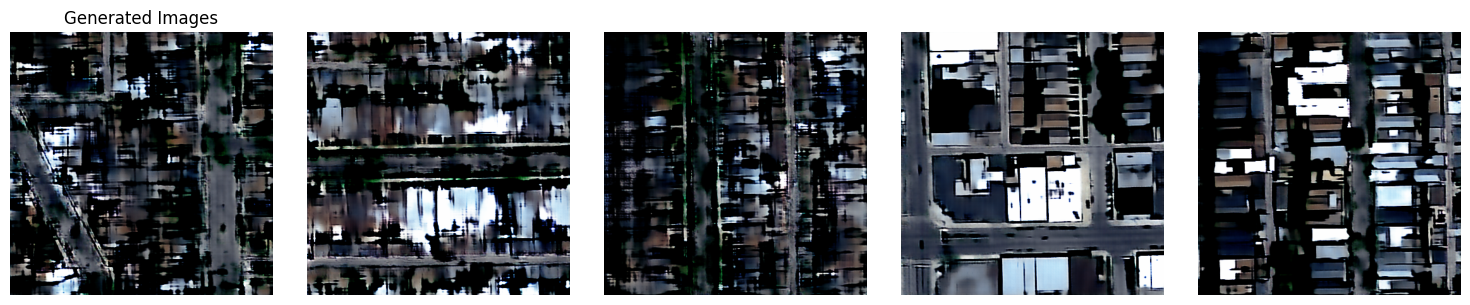

In [31]:
def visualize_generated_samples(generator, dataset, num_samples=5, figsize=(15, 3)):
    """
    Visualize only the generated images from the GAN
    
    """
    generator.eval()  # Set generator to evaluation mode
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(len(dataset))
            _, mask = dataset[idx]
            
            # Ensure mask has correct dimensions
            if mask.dim() == 3:
                mask = mask.unsqueeze(0)
            else:
                mask = mask.unsqueeze(0).unsqueeze(0)
                
            # Generate image
            mask = mask.to(device)
            generated_image = generator(mask)
            
            # Convert to numpy and adjust format
            gen_img = generated_image.cpu().squeeze(0).numpy()
            gen_img = np.transpose(gen_img, (1, 2, 0))
            # Denormalize
            gen_img = (gen_img * 0.5 + 0.5).clip(0, 1)
            
            # Display
            axes[i].imshow(gen_img)
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title('Generated Images')
    
    plt.tight_layout()
    plt.show()

visualize_generated_samples(gan.generator, train_val_dataset)


# save the generated images and masks

In [32]:
def save_generated_samples(images, masks, image_dir, mask_dir):
    """
    Save generated images and masks to specified directories
    """
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    
    # Denormalize images
    denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    for idx, (image, mask) in enumerate(zip(images, masks)):
        # Denormalize and convert image to PIL
        image = denorm(image)
        image = torch.clamp(image, 0, 1)
        image_pil = transforms.ToPILImage()(image)
        
        # Convert mask to PIL
        mask_pil = transforms.ToPILImage()(mask.squeeze())
        
        # Save files
        image_path = os.path.join(image_dir, f'generated_image_{idx:04d}.png')
        mask_path = os.path.join(mask_dir, f'generated_image_{idx:04d}.png')
        
        image_pil.save(image_path)
        mask_pil.save(mask_path)
    
    print(f"Saved {len(images)} generated images and masks")

image_dir = r"C:\Users\study\Downloads\satellite-images-for-road-segmentation\training\images_generated"
mask_dir =  r" C:\Users\study\Downloads\satellite-images-for-road-segmentation\training\groundtruth_generated"

save_generated_samples(new_images, new_masks, image_dir, mask_dir)

Saved 1000 generated images and masks


# Load the augmented dataset for use

In [33]:
class LoadAugmentedDataset(Dataset):
    def __init__(self, original_dataset, generated_image_dir, generated_mask_dir, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform
        
        # Get list of generated images
        self.generated_images = sorted(os.listdir(generated_image_dir))
        self.generated_image_dir = generated_image_dir
        self.generated_mask_dir = generated_mask_dir

    def __len__(self):
        return len(self.original_dataset) + len(self.generated_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            # Load generated image and mask
            idx = idx - len(self.original_dataset)
            image_name = self.generated_images[idx]
            
            image_path = os.path.join(self.generated_image_dir, image_name)
            mask_path = os.path.join(self.generated_mask_dir, image_name)
            
            image = Image.open(image_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')
            
            if self.transform:
                image = self.transform(image)
            
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()
            
            return image, mask

In [34]:
# Create the augmented dataset with both original and generated data
augmented_dataset = LoadAugmentedDataset(
    original_dataset=train_val_dataset,  
    generated_image_dir="/kaggle/input/satellite-images-for-road-segmentation/training/images_generated",
    generated_mask_dir="/kaggle/input/satellite-images-for-road-segmentation/training/groundtruth_generated",
    transform=transform
)

# Split the augmented dataset into train and validation
train_size = int(0.75 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(augmented_dataset, [train_size, val_size])

# Create new dataloaders with the augmented dataset (test_loader created at the beginning above)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [35]:
print(train_size)
print(val_size)

827
276


# Loading Unet model, and training on the dataset

In [36]:
torch.save({'model_state_dict': model.state_dict()}, "/kaggle/working/best_model.pth")


In [37]:
import os

if os.path.exists("/kaggle/working/best_model.pth"):
    print("✅ Model saved successfully!")
else:
    print("❌ Model NOT found. Check the save path.")

✅ Model saved successfully!


In [38]:
# Initialize pre-trained UNet model
model = Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=1,                      
).to(device)

In [39]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
num_epochs = 10
val_f1, history = train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10] Train Loss: 0.6125, Val Loss: 0.5062, Val F1: 0.6759
Epoch [2/10] Train Loss: 0.3760, Val Loss: 0.3178, Val F1: 0.8470
Epoch [3/10] Train Loss: 0.2909, Val Loss: 0.2647, Val F1: 0.8920
Epoch [4/10] Train Loss: 0.2408, Val Loss: 0.2205, Val F1: 0.9288
Epoch [5/10] Train Loss: 0.2047, Val Loss: 0.1931, Val F1: 0.9421
Epoch [6/10] Train Loss: 0.1767, Val Loss: 0.1713, Val F1: 0.9531
Epoch [7/10] Train Loss: 0.1555, Val Loss: 0.1552, Val F1: 0.9566
Epoch [8/10] Train Loss: 0.1381, Val Loss: 0.1380, Val F1: 0.9661
Epoch [9/10] Train Loss: 0.1251, Val Loss: 0.1267, Val F1: 0.9670
Epoch [10/10] Train Loss: 0.1144, Val Loss: 0.1149, Val F1: 0.9704


# Testing and evaluating F1-score on the augmented dataset

In [40]:
def test_model_f1_scores(model, test_loader, output_dir='/kaggle/working/Predictions'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    test_f1_scores = []
    
    with torch.no_grad():
        for images, image_names in test_loader:
            images = images.to(device)
            
            # Generate predictions
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate F1 score
            batch_f1 = f1_score(predictions.cpu().numpy().flatten(), 
                              outputs.cpu().numpy().flatten() > 0.5)
            test_f1_scores.append(batch_f1)
            
            # Save predictions
            for pred, name in zip(predictions, image_names):
                # Convert prediction to image
                pred_img = (pred.cpu().numpy()[0] * 255).astype(np.uint8)
                pred_img = Image.fromarray(pred_img)
                pred_img = pred_img.resize((400, 400))
                
                # Create directory and save
                test_num = name.split(os.sep)[0]
                os.makedirs(os.path.join(output_dir, test_num), exist_ok=True)
                save_path = os.path.join(output_dir, test_num, 'prediction.png')
                pred_img.save(save_path)
    
    print(f"Completed predictions for {len(test_loader.dataset)} test images")
    return test_f1_scores

In [41]:
checkpoint = torch.load('/kaggle/working/best_model.pth')

# Extract just the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-41-c10c21d46176>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/best_model.pth')


<All keys matched successfully>

In [42]:
f1_scores = test_model_f1_scores(model, test_loader)

Completed predictions for 50 test images


In [43]:
print(f'Min F1 Score: {min(f1_scores):.4f}')
print(f'Max F1 Score: {max(f1_scores):.4f}')

Min F1 Score: 0.9121
Max F1 Score: 0.9611
